# WeRateDogs Data Wrangling Project

In [1]:
import tweepy
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from matplotlib.pyplot import figure

% matplotlib inline

## Gathering Data

We start off by reading the csv file provided by udacity. Using the tweet_id from this file and through twitter API, we get the retweet count and favourite count for those IDs.

We get our first dataframe by reading the csv file

In [2]:
#read twitter archive data after uploading it to notebook
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
tweet_id_values=list(twitter_archive['tweet_id'])

We get our second dataframe through twitter API

In [3]:
consumer_key = 'xxxx'
consumer_secret = 'xxxx'
access_token = 'xxxx'
access_secret = 'xxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True )

In [4]:
with open('tweet.json.txt', 'w') as outfile:
    for i in tweet_id_values:
        try:
            tweet = api.get_status(i,tweet_mode = 'extended')
            json.dump(tweet._json, outfile)
            #new line every tweet
            outfile.write('\n')
        except tweepy.TweepError:
            print('Deleted tweet')

In [5]:
#I used this to see what were the columns in the file
#tweet.keys()

In [6]:
#create empty list, loop through the json file creating a dictionary
#for the data we need, append to the list to create a dataframe later

tweets_list = []
with open('tweet.json.txt','r') as outfile:
    for i in outfile:
        tweet = json.loads(i)
        tweet_id = tweet['id']
        retweets = tweet['retweet_count']
        favourited = tweet['favorite_count']
        tweets_list.append({'tweet_id': tweet_id,
                           'retweets': retweets,
                           'favourited': favourited})
        

In [7]:
tweets_df = pd.DataFrame(tweets_list)
tweets_df.sample(5)

,favourited,retweets,tweet_id
1924,852,278,673709992831262724
1071,10318,3628,737800304142471168
950,3235,1018,750147208377409536
1888,1074,364,674447403907457024
1244,2856,927,710140971284037632


We will get our third dataframe here by using requests library to get image predictions

In [8]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(URL)

with open(URL.split('/')[-1], mode = 'wb') as output:
    output.write(r.content)


In [9]:
image_df = pd.read_csv('image-predictions.tsv', sep = '\t')
image_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
130,668291999406125056,https://pbs.twimg.com/media/CUZABzGW4AE5F0k.jpg,1,web_site,0.995535,False,skunk,0.001363,False,badger,0.000686,False
1261,748932637671223296,https://pbs.twimg.com/media/CmS-QkQWAAAkUa-.jpg,1,borzoi,0.742912,True,wire-haired_fox_terrier,0.204082,True,English_setter,0.021032,True
1086,718631497683582976,https://pbs.twimg.com/media/CfkXiX6W4AAmICF.jpg,1,Pomeranian,0.993718,True,Pekinese,0.003611,True,Persian_cat,0.000525,False
999,708479650088034305,https://pbs.twimg.com/media/CdUGcLMWAAI42q0.jpg,1,Shih-Tzu,0.218479,True,Lhasa,0.201966,True,Norfolk_terrier,0.165225,True
1366,761672994376806400,https://pbs.twimg.com/ext_tw_video_thumb/76167...,1,gondola,0.318851,False,sea_lion,0.306525,False,pool_table,0.111565,False


## Assessing Data

In this section I will assess the data. I will identify key quality and tidiness issues and we will proceed in by cleaning these in the next section

Through programmatic and viusal assessment, I have made a list of the issues associated witht the data set:

### Data Quality

- The three dataframes have different number of tweet_ids
- There are retweeted tweets in twitter_archive_data
- Retweeted status timestamp in twitter_archive is a string
- There are some denominators that are greater than 10 in twitter_archive
- There are outliers in numerators in twitter_archive
- Timestamp is a string rather than datetime
- There are missing dog names
- There are dogs that are only called 'a'
- P1 has mix of upper case and lower case letters, no standard

### Data Tidiness

- doggo, floofer, pupper, puppo should be combined to one column.
- There are three dataframes, while we only need 2 or even just one
- There are three probabilities in image_df, we will only be using p1

In [10]:
print(tweets_df.shape, twitter_archive.shape)

(2337, 3) (2356, 17)


In [11]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
favourited    2337 non-null int64
retweets      2337 non-null int64
tweet_id      2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [12]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
2186,668981893510119424,NaN,NaN,2015-11-24 02:38:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unique dog here. Oddly shaped tail. Long pink ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668981893...,4,10,None,None,None,None,None
957,751538714308972544,NaN,NaN,2016-07-08 22:09:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Max. She has one ear that's always sli...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751538714...,10,10,Max,None,None,None,None
1215,715009755312439296,NaN,NaN,2016-03-30 02:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Siba. She's remarkably mobile. Very sl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715009755...,12,10,Siba,None,None,None,None
2006,672267570918129665,NaN,NaN,2015-12-03 04:14:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you accidentally open up the front facing...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672267570...,10,10,None,None,None,None,None
1355,703611486317502464,NaN,NaN,2016-02-27 16:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Scooter. He's experiencing the pupper equ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703611486...,10,10,Scooter,None,None,pupper,None
1198,716802964044845056,NaN,NaN,2016-04-04 01:41:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Link. He struggles with couches. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716802964...,10,10,Link,None,None,None,None
2221,668480044826800133,NaN,NaN,2015-11-22 17:23:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to DayZ. She is definitely stuck on ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668480044...,11,10,DayZ,None,None,None,None
1847,675820929667219457,NaN,NaN,2015-12-12 23:34:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a handful of sleepy puppers. All look u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675820929...,11,10,None,None,None,None,None
245,845812042753855489,NaN,NaN,2017-03-26 01:38:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We usually don't rate polar bears but this one...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/845812042...,13,10,None,None,None,None,None


## Cleaning Data

In this section we will clean the data solving the problems we found in the previous section.

In [15]:
#make copies of the original dataframes
twitter_archive_clean = twitter_archive.copy()
image_df_clean = image_df.copy()
tweets_df_clean = tweets_df.copy()

In [16]:
#write function to convert string to datetime
def convert_to_datetime(date):
    x = pd.to_datetime(date)
    return x

twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].apply(convert_to_datetime)
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

I have successfully converted the string to datetime

In [17]:
#double checking we don't have any tweets later than august 1st, 2017
twitter_archive_cleaner_old = twitter_archive_clean[twitter_archive_clean['timestamp'] >= '2017-8-2']
twitter_archive_cleaner_old.shape

(0, 17)

Lets get rid of the retweeted tweets

In [18]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

In [19]:
tweets_df_idlist =tweets_df_clean.tweet_id.unique()

In [20]:
missing= twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(tweets_df_idlist)]

In [21]:
#we can keep these as they are original teweets
missing

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,None,None,None,None
253,844704788403113984,NaN,NaN,2017-03-23 00:18:10,"<a href=""http://twitter.com/download/iphone"" r...",This is Luna. It's her first time outside and ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/844704788...,13,10,Luna,None,None,None,None
932,754011816964026368,NaN,NaN,2016-07-15 17:56:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He pouts until he gets to go ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754011816...,12,10,Charlie,None,None,None,None
1726,680055455951884288,NaN,NaN,2015-12-24 16:00:30,"<a href=""https://about.twitter.com/products/tw...","Meet Sammy. At first I was like ""that's a snow...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None


Lets drop the columns we don't need

In [22]:
twitter_archive_clean = twitter_archive_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','source','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls'])

Investigate the denominators that are greater than 10

In [23]:
pd.set_option('display.width', 1000)

denom_outliers = twitter_archive_clean.query("rating_denominator > 10")
denom_outliers.style.set_properties(subset=['text'], **{'width': '300px'})

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,2017-02-16 04:45:50,@docmisterio account started on 11/15/15,11,15,None,None,None,None,None
433,820690176645140481,2017-01-15 17:52:40,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,None,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,None,None,None,None,None
1068,740373189193256964,2016-06-08 02:41:38,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,None,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,this,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50,Bluebert,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08,"From left to right: Cletus, Jerome, Alejandro, Burp, & Titson None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50,None,None,None,None,None


In [24]:
#These are the errors that do not have a denominator of 10 and the text does not give a correct rating
id_errors = [ 832088576586297345,820690176645140481,758467244762497024,
            731156023742988288,713900603437621249,710658690886586372,
            709198395643068416,704054845121142784,697463031882764288,
            686035780142297088,684225744407494656,684222868335505415,
            682808988178739200,677716515794329600,675853064436391936 ]

In [25]:
#Set the correct values for these tweets

twitter_archive_clean.at[1068,'rating_numerator'] = 11
twitter_archive_clean.at[1068,'rating_denominator'] = 10

twitter_archive_clean.at[1165,'rating_numerator'] = 13
twitter_archive_clean.at[1165,'rating_denominator'] = 10

twitter_archive_clean.at[1202,'rating_numerator'] = 11
twitter_archive_clean.at[1202,'rating_denominator'] = 10

twitter_archive_clean.at[1662,'rating_numerator'] = 10
twitter_archive_clean.at[1662,'rating_denominator'] = 10


#Drop the tweets that we don't have ratings for
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(id_errors)]

denom_outliers should now be an empty dataframe as we have dropped the errors and corrected the ones we could find ratings for

In [26]:
denom_outliers = twitter_archive_clean.query("rating_denominator > 10")
denom_outliers = denom_outliers[~denom_outliers['tweet_id'].isin(id_errors)]
denom_outliers

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
#check to see if this works
twitter_archive_clean['rating_denominator'][1165]

10

Lets look at the outlier numerators

In [28]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
twitter_archive_clean.sort_values(by = ['rating_numerator'], ascending=False)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,2016-07-04 15:00:45,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10,Atticus,None,None,None,None
313,835246439529840640,2017-02-24 21:54:03,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0,None,None,None,None,None
189,855860136149123072,2017-04-22 19:05:32,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10,None,None,None,None,None
188,855862651834028034,2017-04-22 19:15:32,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10,None,None,None,None,None
2074,670842764863651840,2015-11-29 05:52:33,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10,None,None,None,None,None
290,838150277551247360,2017-03-04 22:12:52,@markhoppus 182/10,182,10,None,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10,Sophie,None,None,pupper,None
1712,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,None,None,None,None,None
516,810984652412424192,2016-12-19 23:06:23,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,Sam,None,None,None,None


In [29]:
twitter_archive_clean.at[313,'rating_numerator'] = 13
twitter_archive_clean.at[313,'rating_denominator'] = 10

twitter_archive_clean.at[695,'rating_numerator'] = 10 # rounded up figure
twitter_archive_clean.at[763,'rating_numerator'] = 11
twitter_archive_clean.at[1712,'rating_numerator'] = 11
twitter_archive_clean.at[55,'rating_numerator'] = 13

In [30]:
#we know the biggest correct rating is 14
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_numerator <15]

We should now have all the numerator and denominator outliers removed

In [31]:
twitter_archive_clean.sort_values(by = ['rating_numerator'], ascending=False).head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
184,856526610513747968,2017-04-24 15:13:52,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",14,10,None,None,None,None,None
149,863079547188785154,2017-05-12 17:12:53,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",14,10,None,None,None,None,None
214,851464819735769094,2017-04-10 16:00:07,This is Iggy. He was a rescue dog killed in the Stockholm attack. His memorial started with a collar and four bones. It's grown a bit. 14/10 https://t.co/E4a0R9my1M,14,10,Iggy,None,None,None,None
631,794205286408003585,2016-11-03 15:51:10,This is Laika. She was a space pupper. The first space pupper actually. Orbited earth like a h*ckin boss. 14/10 hero af https://t.co/trSjgY3h4g,14,10,Laika,None,None,pupper,None
35,885518971528720385,2017-07-13 15:19:09,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,14,10,None,None,None,None,None


Lets convert the timestamp to datetime

In [32]:
def get_datetime(date):
    x = pd.to_datetime(date, format = '%Y-%m-%d %H:%m:%s')
    return x

twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].apply(get_datetime)

Lets check to see if the timestamp has been successfully converted

In [33]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2153 non-null int64
timestamp             2153 non-null datetime64[ns]
text                  2153 non-null object
rating_numerator      2153 non-null int64
rating_denominator    2153 non-null int64
name                  2153 non-null object
doggo                 2153 non-null object
floofer               2153 non-null object
pupper                2153 non-null object
puppo                 2153 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 185.0+ KB


Lets correct naming error's with name 'a' and 'an' as much as possible

In [34]:
twitter_archive_clean.at[2204,'name'] = 'Berta'
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['name'] != 'an']

In [35]:
twitter_archive_clean[twitter_archive_clean['name'] == 'a']

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,2017-07-02 15:32:16,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,14,10,a,None,None,pupper,None
649,792913359805018113,2016-10-31 02:17:31,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,13,10,a,None,None,None,None
801,772581559778025472,2016-09-04 23:46:12,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,10,10,a,None,None,None,None
1002,747885874273214464,2016-06-28 20:14:22,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,8,10,a,None,None,None,None
1004,747816857231626240,2016-06-28 15:40:07,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,4,10,a,None,None,None,None
1017,746872823977771008,2016-06-26 01:08:52,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,11,10,a,None,None,None,None
1049,743222593470234624,2016-06-15 23:24:09,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,12,10,a,None,None,pupper,None
1193,717537687239008257,2016-04-06 02:21:30,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,11,10,a,None,None,None,None
1207,715733265223708672,2016-04-01 02:51:22,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9,10,10,a,None,None,None,None
1340,704859558691414016,2016-03-02 02:43:09,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,10,10,a,None,None,pupper,None


In [36]:
twitter_archive_clean.at[1853,'name'] = 'Wylie'
twitter_archive_clean.at[1955,'name'] = 'Kip'
twitter_archive_clean.at[1994,'name'] = 'Rand'
twitter_archive_clean.at[2034,'name'] = 'Jacob'
twitter_archive_clean.at[2066,'name'] = 'Rufus'
twitter_archive_clean.at[2116,'name'] = 'Spork'
twitter_archive_clean.at[2125,'name'] = 'Cherokee'
twitter_archive_clean.at[2128,'name'] = 'Hemry'
twitter_archive_clean.at[2146,'name'] = 'Alphred'
twitter_archive_clean.at[2161,'name'] = 'Alfredo'
twitter_archive_clean.at[2191,'name'] = 'Leroi'
twitter_archive_clean.at[2218,'name'] = 'Chuk'
twitter_archive_clean.at[2235,'name'] = 'Alfonso'
twitter_archive_clean.at[2249,'name'] = 'Cheryl'
twitter_archive_clean.at[2225,'name'] = 'Jessiga'
twitter_archive_clean.at[2264,'name'] = 'Kint'
twitter_archive_clean.at[2273,'name'] = 'Kohl'
twitter_archive_clean.at[2287,'name'] = 'Daryl'
twitter_archive_clean.at[2304,'name'] = 'Pepe'
twitter_archive_clean.at[2314,'name'] = 'Johm'

In [37]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['name'] != 'a']

Lets combine all the different dog types into one column

In [38]:
twitter_archive_clean['doggo'] = twitter_archive_clean['doggo'].str.replace('None','')
twitter_archive_clean['floofer'] = twitter_archive_clean['floofer'].str.replace('None','')
twitter_archive_clean['pupper'] = twitter_archive_clean['pupper'].str.replace('None','')
twitter_archive_clean['puppo'] = twitter_archive_clean['puppo'].str.replace('None','')

In [39]:
twitter_archive_clean['stage'] = twitter_archive_clean['doggo'] + twitter_archive_clean['floofer'] + twitter_archive_clean['pupper'] + twitter_archive_clean['puppo'] 

In [40]:
twitter_archive_clean['stage'] = twitter_archive_clean['stage'].str.strip()
twitter_archive_clean = twitter_archive_clean.drop(columns = ['doggo','floofer','pupper','puppo'])

In [41]:
twitter_archive_clean.sample(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage
2244,667886921285246976,2015-11-21 02:07:05,This is Erik. He's fucken massive. But also kind. Let's people hug him for free. Looks soft. 11/10 I would hug Erik https://t.co/MT7Q4aDQS1,11,10,Erik,
2040,671544874165002241,2015-12-01 04:22:29,Interesting dog here. Very large. Purple. Manifests rainbows. Perfect teeth. No ears. Surprisingly knowledgable 6/10 https://t.co/QVaEMsB9tS,6,10,None,


In [42]:
image_df_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
392,673580926094458881,https://pbs.twimg.com/media/CVkKRqOXIAEX83-.jpg,1,beagle,0.985062,True,basset,0.006418,True,Walker_hound,0.003533,True
1618,802572683846291456,https://pbs.twimg.com/media/CyNPmJgXcAECPuB.jpg,1,golden_retriever,0.610171,True,Labrador_retriever,0.173252,True,cocker_spaniel,0.163257,True
1983,871879754684805121,https://pbs.twimg.com/media/DBmKAmBXUAE-pQ-.jpg,1,Shetland_sheepdog,0.969171,True,collie,0.018261,True,Pomeranian,0.008515,True
675,683449695444799489,https://pbs.twimg.com/media/CXwZ3pbWsAAriTv.jpg,1,Lakeland_terrier,0.303512,True,soft-coated_wheaten_terrier,0.211424,True,golden_retriever,0.170725,True
1346,759197388317847553,https://pbs.twimg.com/media/Cok1_sjXgAU3xpp.jpg,1,kuvasz,0.511341,True,golden_retriever,0.076899,True,white_wolf,0.063269,False


In [43]:
image_df_clean = image_df_clean.drop(columns=['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'])

In [44]:
image_df_clean.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
876,698262614669991936,https://pbs.twimg.com/media/CbC6JL_WEAI_PhH.jpg,1,Italian_greyhound,0.107948,True
1924,857263160327368704,https://pbs.twimg.com/media/C-WcS4MXoAADrBU.jpg,1,Samoyed,0.998021,True


We can't go back and get the missing dog names, so we will drop this to keep a full data set as the name will be used for analysis later on

In [45]:
twitter_archive_clean.shape

(2113, 7)

In [46]:
twitter_archive_clean = twitter_archive_clean.dropna(subset=['name'])
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['name'] != 'None']

In [47]:
twitter_archive_clean.shape

(1451, 7)

In [48]:
twitter_archive_clean.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage
139,865359393868664832,2017-05-19 00:12:11,This is Sammy. Her tongue ejects without warning sometimes. It's a serious condition. Needs a hefty dose from a BlepiPen. 13/10 https://t.co/g20EmqK7vc,13,10,Sammy,
724,782747134529531904,2016-10-03 01:00:34,This is Deacon. He's the happiest almost dry doggo I've ever seen. 11/10 would smile back https://t.co/C6fUMnHt1H,11,10,Deacon,doggo
1879,675015141583413248,2015-12-10 18:12:05,Meet Moe. He's a golden Fetty Woof. Doesn't respect the authorities. Might own a motorhome? 10/10 revolutionary pup https://t.co/JAncIdNp8G,10,10,Moe,
106,871879754684805121,2017-06-06 00:01:46,Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner. 13/10 https://t.co/uK6PNyeh9w,13,10,Lassie,
861,763103485927849985,2016-08-09 20:03:43,This is Belle. She's a Butterflop Hufflepoof. Rarer than most. Having trouble with car seat. 10/10 perturbed af https://t.co/VIXT3D26VM,10,10,Belle,
1731,679844490799091713,2015-12-24 02:02:12,This is Willie. He's floating away and needs your assistance. Please someone help Willie. 10/10 https://t.co/MJqygWqt8X,10,10,Willie,
2164,669371483794317312,2015-11-25 04:26:12,This is Oliviér. He's a Baptist Hindquarter. Also smooth af with the babes. 10/10 I'd totally get in a car with him https://t.co/fj4c170cxk,10,10,Oliviér,
392,826115272272650244,2017-01-30 17:10:04,This is Ike. He's demonstrating the pupmost restraint. 13/10 super good boy https://t.co/6gHoGah9nm,13,10,Ike,
1169,720785406564900865,2016-04-15 01:26:47,This is Archie. He hears everything you say. Doesn't matter where you are. 12/10 https://t.co/0l4I8famYp,12,10,Archie,
1195,717421804990701568,2016-04-05 18:41:02,This is Ebby. She's a Zimbabwean Feta. Embarrassed by ridiculously squishy face. 9/10 would squeeze softly https://t.co/LBJqxMGaHi,9,10,Ebby,


We can now combine the dataframes to get a master dataset

In [49]:
clean_twitter = twitter_archive_clean.merge(image_df_clean, on ='tweet_id', how = 'left')
clean_twitter = clean_twitter.merge(tweets_df_clean, on = 'tweet_id')

In [50]:
clean_twitter.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,favourited,retweets
398,789530877013393408,2016-10-21 18:16:44,This is Rizzy. She smiles a lot. 12/10 contagious af https://t.co/TU4sZogVIq,12,10,Rizzy,,https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg,3.0,schipperke,0.363272,True,12425,3650
1219,672614745925664768,2015-12-04 03:13:46,This is Norman. Doesn't bark much. Very docile pup. Up to date on current events. Overall nifty pupper. 6/10 https://t.co/ntxsR98f3U,6,10,Norman,pupper,https://pbs.twimg.com/media/CVWbitUW4AAzclx.jpg,1.0,starfish,0.712717,False,1225,595
233,826958653328592898,2017-02-02 01:01:21,This is Loki. He smiles like Elvis. Ain't nothin but a hound doggo. 12/10 https://t.co/QV5nx6otZR,12,10,Loki,doggo,https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg,1.0,golden_retriever,0.617389,True,22507,5347
1098,678740035362037760,2015-12-21 00:53:29,Meet Tango. He's a large dog. Doesn't care much for personal space. Owner isn't very accepting. Tongue slip. 6/10 https://t.co/p2T5kGebxe,6,10,Tango,,https://pbs.twimg.com/media/CWtede2WIAAF_AJ.jpg,1.0,seat_belt,0.787164,False,3861,1773
733,718234618122661888,2016-04-08 00:30:51,This is Suki. She was born with a blurry tail (unfortunate). Next level tongue tho. 11/10 nifty hardwood https://t.co/05S8oYztgb,11,10,Suki,,https://pbs.twimg.com/media/CfeukpmW4AEGjOE.jpg,1.0,malamute,0.370152,True,3991,1051


In [51]:
clean_twitter.to_csv('twitter_archive_master.csv')

## Analyse Data

Do dog names affect its popularity?

In [52]:
dog_names = list(clean_twitter['name'].unique())

dog_df = clean_twitter.filter(items = ['name','rating_numerator'])
dog_df = dog_df.set_index('name')
dog_names_list = []

for i in dog_names:
    numerators = np.array(dog_df.loc[i])
    count_dog  = len(numerators)
    mean_dog =  sum(numerators)/len(numerators)
    dog_names_list.append({'name': i,
                          'count': count_dog,
                          'mean': mean_dog})

In [53]:
dog_names_df = pd.DataFrame(dog_names_list)
dog_names_df['mean'] = dog_names_df['mean'].astype(float)
dog_names_df.head()

,count,mean,name
0,2,11.5,Phineas
1,1,13.0,Tilly
2,4,11.5,Archie
3,1,13.0,Darla
4,2,11.5,Franklin


In [54]:
top_10_names_count = dog_names_df.sort_values(by = 'count',ascending = False)[:14]

Text(0.5,0,'Name')

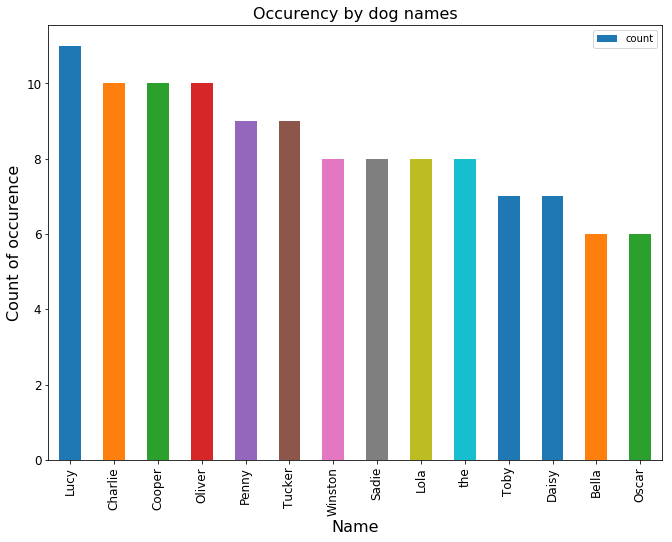

In [215]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
top_10_names_count.plot.bar(x = 'name',y = 'count')
plt.title('Occurency by dog names', fontsize = )
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Count of occurence', fontsize = 16)
plt.xlabel('Name', fontsize = 16)

Lucy looks like the most popular name, while Charlie, Oliver, Cooper and Tucker/Penny are also in the top 5

To compare the mean, we will only look at names that have more than 5 ratings

In [56]:
top_10_names_mean = dog_names_df[dog_names_df['count'] > 4]
top_10_names_mean = top_10_names_mean.sort_values(by = 'mean',ascending = False)[:10]
top_10_names_mean

,count,mean,name
230,6,12.166667,Bo
124,5,12.000000,Leo
166,9,12.000000,Tucker
42,5,12.000000,Louis
133,7,11.857143,Daisy
8,6,11.666667,Koda
141,10,11.600000,Charlie
36,6,11.333333,Stanley
79,10,11.300000,Cooper
12,10,11.300000,Oliver


(array([ 10. ,  10.5,  11. ,  11.5,  12. ,  12.5]),
 <a list of 6 Text yticklabel objects>)

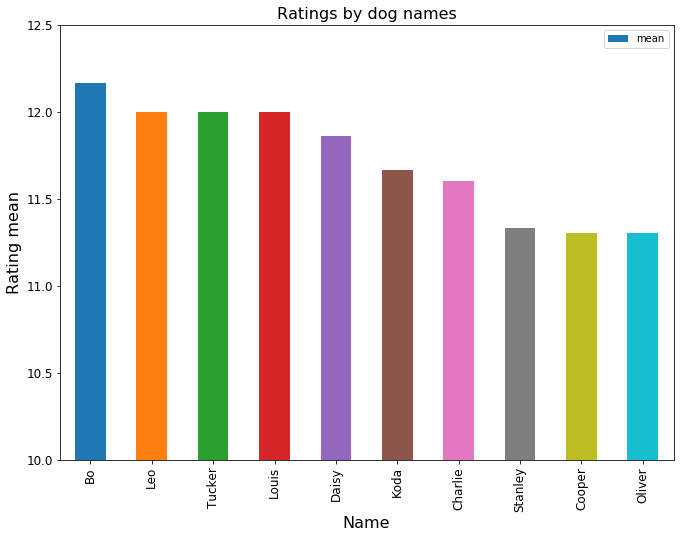

In [216]:
top_10_names_mean.plot.bar(x = 'name',y = 'mean')
plt.ylim(10,12.5)
plt.title('Ratings by dog names', fontsize = 16)
plt.xlabel('Name', fontsize = 16)
plt.ylabel('Rating mean', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


Maybe the time of the tweet has a stronger correlation to popularity?

In [73]:
popular_time =clean_twitter.filter(items=['timestamp','retweets','favourited'])

In [74]:
popular_time.head()

,timestamp,retweets,favourited
0,2017-08-01 16:23:56,8182,37516
1,2017-08-01 00:17:27,6053,32244
2,2017-07-31 00:18:03,4004,24297
3,2017-07-30 15:58:51,8331,40857
4,2017-07-29 16:00:24,9032,39063


In [75]:
hour = []
for index, row in popular_time.iterrows():
    i = row['timestamp'].hour
    hour.append(i)

In [76]:
popular_time['Hour'] = hour

In [77]:
popular_time.sample(5)

,timestamp,retweets,favourited,Hour
885,2016-02-13 03:59:01,476,1935,3
905,2016-02-07 18:51:43,1201,3320,18
1319,2015-11-27 02:55:47,800,1578,2
1214,2015-12-04 22:00:08,428,909,22
1095,2015-12-21 02:41:11,1437,3641,2


In [217]:
hour_retweet_fav = popular_time.filter(items=['retweets','Hour','favourited'])
hour_retweet_fav.shape

(1447, 3)

In [98]:
hour_rt_pivot = pd.pivot_table(hour_retweet_fav,index ='Hour', aggfunc = np.mean).sort_values('Hour', ascending = True)
hour_rt_pivot.head()

,favourited,retweets
Hour,,
0,13400.160428,3591.636364
1,8497.743590,2461.800000
2,4043.381944,1480.743056
3,4529.910714,1479.446429
4,3880.836066,1366.885246


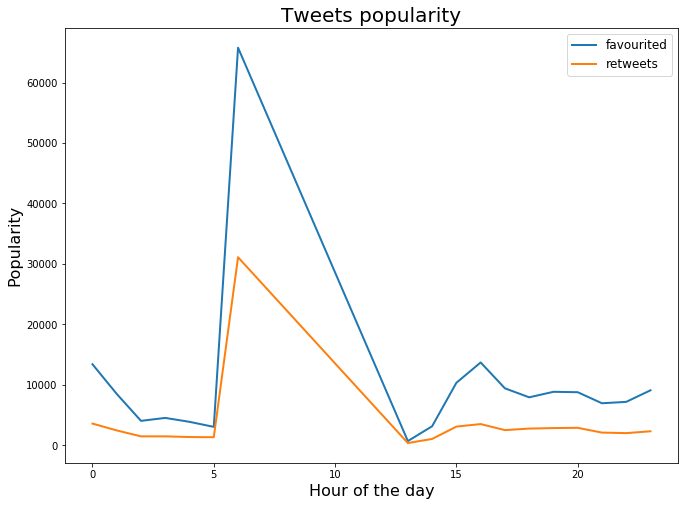

In [136]:
plt.rcParams['figure.figsize'] = [11, 8]
hour_rt_pivot.plot(linewidth = 2.0)
plt.title('Tweets popularity', fontsize = 20)
plt.xlabel('Hour of the day', fontsize = 16)
plt.ylabel('Popularity', fontsize = 16)
plt.legend(fontsize=12)

There is drastic increase in favourited tweets and retweeted tweets just after 5am. This might be due to the dog owners taking their dogs on morning walks.

In [211]:
name_retweet_fav = clean_twitter.filter(items=['retweets','favourited','name'])
#remove some outliers
name_retweet_fav = name_retweet_fav[~name_retweet_fav['name'].isin(['Stephan','Jamesy','Duddles'])]
name_retweet_pivot = pd.pivot_table(name_retweet_fav,index ='name', aggfunc = np.mean).sort_values('favourited', ascending = False)
name_retweet_pivot.head()

,favourited,retweets
name,,
Aja,77356.0,18469.0
Lilly,69604.0,17880.0
Canela,66848.0,17497.0
Pipsy,47248.0,16953.0
Barney,45727.0,12078.0


Text(0,0.5,'Retweeted')

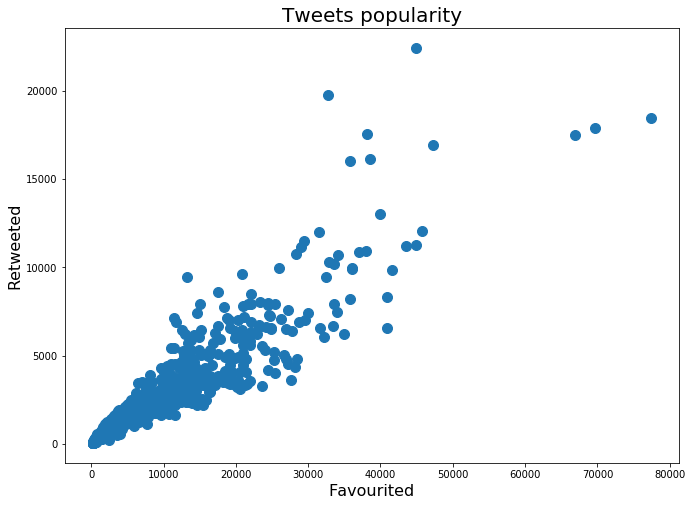

In [213]:
plt.scatter(name_retweet_pivot['favourited'],name_retweet_pivot['retweets'],s=100 )
plt.title('Tweets popularity', fontsize = 20)
plt.xlabel('Favourited', fontsize = 16)
plt.ylabel('Retweeted', fontsize = 16)